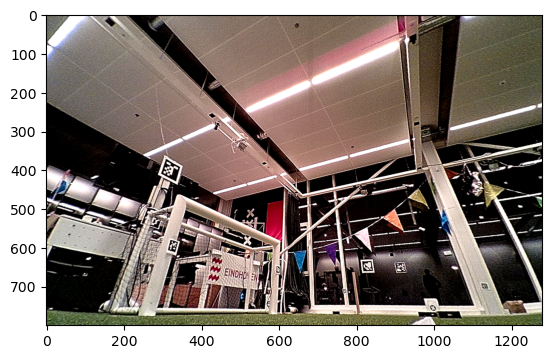

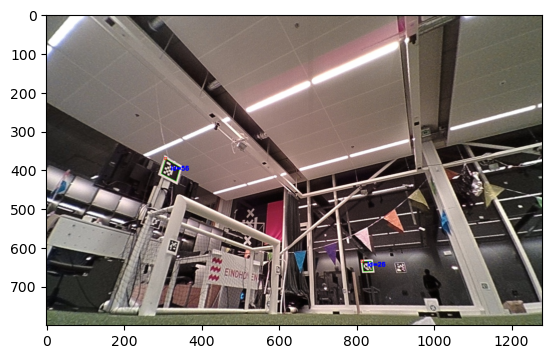

In [4]:
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

RETDICT = {
    aruco.DICT_7X7_100: "DICT_7X7_100",
    aruco.DICT_APRILTAG_36h11: "DICT_APRILTAG_36h11",
    aruco.DICT_6X6_100: "DICT_6X6_100",
}


# Dimensions in mm
A = 9000  # Field length
B = 6000  # Field width
C = 50  # Line width
D = 100  # Penalty mark size
E = 600  # Goal area length
F = 2200  # Goal area width
G = 1650  # Penalty area length
H = 4000  # Penalty area width
I = 1300  # Penalty mark distance
J = 1500  # Center circle diameter
K = 2700  # Border strip width

# Unique marker keys with (x, x, z (in mm), length_of_square (in m))
markers = {
    # window
    # "36H11_
    "79": (-4500, 1060 + 3000 + 50, 510, 0.08),
    # "36H11_
    "26": (-4500 + 450, 130 + 1060 + 3000 + 50, 1080, 0.235),
    # "36H12_
    "67": (-4500 + 450 + 530 + 80, 130 + 1060 + 3000 + 50, 1000, 0.2),
    # "36H11_
    "69": (-1800, 620 + 3000 + 50, 500, 0.08),
    # "36H11_
    "18": (0, 130 + 1060 + 3000 + 50, 1050, 0.28),
    # "36H12_
    "47": (840, 130 + 1060 + 3000 + 50, 1050, 0.2),
    # "36H11_
    "9": (840 + 850, 1060 + 3000 + 50, 500, 0.08),
    # "36H11_
    "66": (840 + 850 + 1150, 130 + 1060 + 3000 + 50, 1100, 0.235),
    # tables
    # "36H11_
    "39": (4500, 1100, 500, 0.08),
    # "36H11_
    "46": (4550 + 820, 0, 1680, 0.235),  # the one up
    # "36H12_
    "57": (4550 + 820, 0, 1000, 0.2),  # the lower one
    # "36H11_
    "49": (4500, -1100, 500, 0.08),
    # wall
    # "36H11_
    "16": (2850, -2000 - 3005, 1070, 0.235),
    # "36H11_
    "19": (2850 - 1050, -2000 - 3005, 510, 0.08),
    # "7x7_
    "37": (2850 - 1050 - 850, -2000 - 3005, 1000, 0.2),
    # "36H11_
    "8": (2850 - 1050 - 850 - 1050, -2000 - 3005, 500, 0.08),  # one on the bottom
    # "36H11_
    "29": (2850 - 1050 - 850 - 1050, -2000 - 3005, 1060, 0.275),  # one on top
    # "36H11_
    "59": (-2800 + 1050, -120 - 3005, 510, 0.08),  # column one
    # "7x7_
    "27": (-2800, -2000 - 3005, 1000, 0.2),  #
    # "36H11_
    "36": (-2800 - 900, -2000 - 3005, 1080, 0.235),
    # ducks
    # "7x7_
    "7": (-4600 - 50 - 930, 0, 1680, 0.2),  # lower one in column
    # "36H11_
    "56": (-4600 - 50 - 930, 0, 1000, 0.235),  # top one in column
    # "36H11_
    "89": (-4500, -1100, 450, 0.08),
    # "36H11_
    "99": (-4500, 1100, 500, 0.08),  # window
}


def detect_aruco_markers(image):
    # Convert the image to grayscale
    # UnSharpen the image
    blurred = cv2.GaussianBlur(image, (3, 3), 5)
    image = cv2.addWeighted(image, 3, blurred, -2, 0)

    # Sharpness filter 4x4
    sharpen_filter = np.array(
        [[-1, -1, -1, -1], [-1, 9, 9, -1], [-1, 9, 9, -1], [-1, -1, -1, -1]]
    )
    sharpened = cv2.filter2D(image, cv2.CV_8U, sharpen_filter)
    image = cv2.addWeighted(image, 1.5, sharpened, -0.25, 0)
    plt.imshow(image[..., ::-1])
    plt.show()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    retdict = RETDICT.copy()

    for key in retdict:
        aruco_dict = aruco.getPredefinedDictionary(key)
        parameters = aruco.DetectorParameters()
        parameters.adaptiveThreshWinSizeStep = 1
        parameters.adaptiveThreshWinSizeMin = 3
        parameters.aprilTagMinWhiteBlackDiff = 3

        corners, ids, rejectedImgPoints = aruco.detectMarkers(
            gray, aruco_dict, parameters=parameters
        )
        retdict[key] = (corners, ids, rejectedImgPoints)
    return retdict


# Load the image
image_path = "marker_imgs/image_4.png"
image = cv2.imread(image_path)

# Detect AruCo markers
retdict = detect_aruco_markers(image)

# Get the detected markers
viz = image.copy()
for key, desci in RETDICT.items():
    corners, ids, rejectedImgPoints = retdict[key]
    if ids is not None:
        viz = aruco.drawDetectedMarkers(viz, corners, ids)
plt.imshow(viz[..., ::-1])


('26', 816.0, 635.0, -3932.5, 4240, 962.5)
('26', 839.0, 635.0, -4167.5, 4240, 962.5)
('26', 843.0, 660.0, -3932.5, 4240, 1197.5)
('26', 819.0, 661.0, -4167.5, 4240, 1197.5)
('56', 308.0, 370.0, -5462.5, 0, 882.5)
('56', 346.0, 392.0, -5697.5, 0, 882.5)
('56', 336.0, 428.0, -5462.5, 0, 1117.5)
('56', 297.0, 409.0, -5697.5, 0, 1117.5)


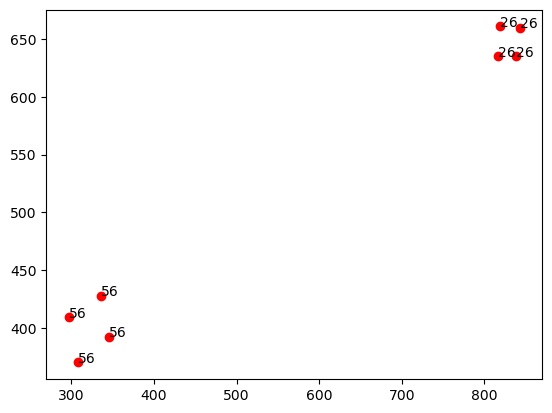

In [14]:
def triangulate_position(markers, retdict):
    positions = {}
    for marker_id, (x, y, z, size) in markers.items():
        size *= 1000  # Convert to mm
        for key, (corners, ids, _) in retdict.items():
            if ids is not None:
                for i, id in enumerate(ids):
                    if str(id[0]) == marker_id:
                        cornerspos = []
                        # Add to positions the 4 corners of the marke
                        cornerspos.append((marker_id, corners[i][0][0][0], corners[i][0][0][1], 
                                          x+ size/2, y, z- size/2))
                        cornerspos.append((marker_id, corners[i][0][1][0], corners[i][0][1][1],
                                            x - size/2, y, z - size/2))
                        cornerspos.append((marker_id, corners[i][0][2][0], corners[i][0][2][1],
                                            x + size/2, y, z+ size/2))
                        cornerspos.append((marker_id, corners[i][0][3][0], corners[i][0][3][1],
                                            x-size/2, y, z + size/2))
                        positions[marker_id] = cornerspos
                        # Calculate the center of the marker
                        # c = corners[i][0]
                        # center_x = int((c[0][0] + c[1][0] + c[2][0] + c[3][0]) / 4)
                        # center_y = int((c[0][1] + c[1][1] + c[2][1] + c[3][1]) / 4)
                        # positions.append((marker_id, center_x, center_y, x, y, z))
                        
    return positions

positions = triangulate_position(markers, retdict)
for key in positions:
    for corner in positions[key]:
        print(corner)
        plt.plot(corner[1], corner[2], 'ro')
        plt.text(corner[1], corner[2], f"{corner[0]}")

In [17]:
mtx = np.loadtxt("mtx")
dist = np.zeros((1, 5))
def find_viewing_angles(positions, camera_matrix, dist_coeffs):
    viewing_angles = {}
    for marker_id, corners in positions.items():
        object_points = []
        image_points = []
        for corner in corners:
            object_points.append([corner[3], corner[4], corner[5]])  # Real world coordinates
            image_points.append([corner[1], corner[2]])  # Image coordinates

        object_points = np.array(object_points, dtype=np.float32)
        image_points = np.array(image_points, dtype=np.float32)

        success, rotation_vector, translation_vector = cv2.solvePnP(
            object_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_SQPNP
        )

        if success:
            viewing_angles[marker_id] = (rotation_vector, translation_vector)
        else:
            viewing_angles[marker_id] = (None, None)
    
    return viewing_angles

viewing_angles = find_viewing_angles(positions, mtx, dist)

for marker_id, (rotation_vector, translation_vector) in viewing_angles.items():
    if rotation_vector is not None and translation_vector is not None:
        print(f"Marker ID: {marker_id}")
        print(f"Rotation Vector:\n{rotation_vector}")
        print(f"Translation Vector:\n{translation_vector}")
    else:
        print(f"Marker ID: {marker_id} - PnP solution could not be found.")

def triangulate_robot_position(viewing_angles):
    # Assuming the robot's position is the average of the translation vectors
    valid_translations = [translation_vector for _, translation_vector in viewing_angles.values() if translation_vector is not None]
    if not valid_translations:
        return None

    avg_translation = np.mean(valid_translations, axis=0)
    return avg_translation

robot_position = triangulate_robot_position(viewing_angles)

if robot_position is not None:
    print(f"Estimated Robot Position:\n{robot_position}")
else:
    print("Could not estimate robot position.")

Marker ID: 26
Rotation Vector:
[[-1.40175954]
 [ 1.71658952]
 [ 1.27520849]]
Translation Vector:
[[ 4050.33941984]
 [-1229.53074799]
 [-1344.49989766]]
Marker ID: 56
Rotation Vector:
[[-0.82972755]
 [-1.62326946]
 [-1.44669986]]
Translation Vector:
[[-3330.69404829]
 [-1161.58750638]
 [ 6473.20373014]]
Estimated Robot Position:
[[  359.82268578]
 [-1195.55912718]
 [ 2564.35191624]]


In [ ]:
def solve_pnp(positions, camera_matrix, dist_coeffs, rvec=None, tvec=None):
    # Prepare 3D points and 2D points
    object_points = []
    image_points = []

    for pos in positions:
        object_points.append([pos[3], pos[4], pos[5]])  # Real world coordinates
        image_points.append([pos[1], pos[2]])  # Image coordinates

    object_points = np.array(object_points, dtype=np.float32)
    image_points = np.array(image_points, dtype=np.float32)

    # Solve PnP
    success, rotation_vector, translation_vector = cv2.solvePnP(
        object_points, image_points, camera_matrix, dist_coeffs, rvec, tvec, flags=cv2.SOLVEPNP_SQPNP
    )

    if success:
        return rotation_vector, translation_vector
    else:
        return None, None

# Example camera matrix and distortion coefficients (you need to calibrate your camera to get these values)
camera_matrix = np.loadtxt("mtx")
dist_coeffs = np.zeros((4, 1))  # Assuming no lens distortion

for i in range(5):
    rotation_vector, translation_vector = solve_pnp(positions, camera_matrix, dist_coeffs)

if rotation_vector is not None and translation_vector is not None:
    print(f"Rotation Vector:\n{rotation_vector}")
    print(f"Translation Vector:\n{translation_vector}")
else:
    print("PnP solution could not be found.")

Rotation Vector:
[[1.36251929]
 [0.89373988]
 [0.47409214]]
Translation Vector:
[[2090.42907991]
 [4862.24116757]
 [-756.38813221]]


[[  359.82268578]
 [-1195.55912718]
 [ 2564.35191624]]


/tmp/ipykernel_53752/604504288.py:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.plot(int(xrobot) +A/2,int(yrobot) +B/2, "ro", zorder=5)


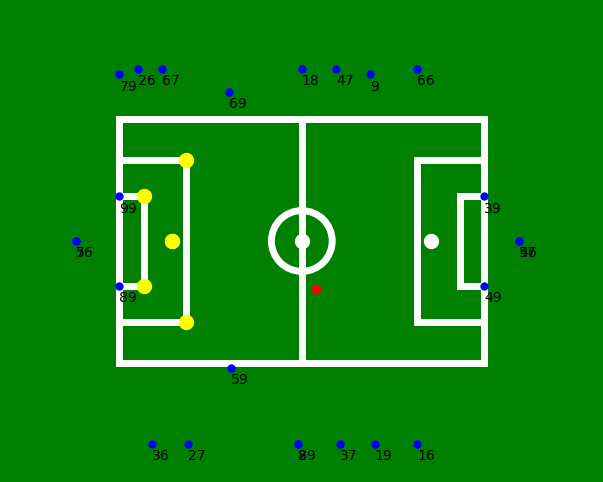

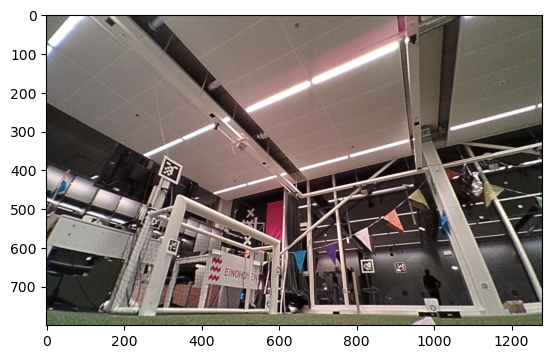

In [26]:
# %reload_ext autoreload
# %autoreload 2
from astar import PathFinder

import matplotlib.pyplot as plt
from matplotlib import patches

# Dimensions in mm
A = 9000  # Field length
B = 6000  # Field width
C = 50  # Line width
D = 100  # Penalty mark size
E = 600  # Goal area length
F = 2200  # Goal area width
G = 1650  # Penalty area length
H = 4000  # Penalty area width
I = 1300  # Penalty mark distance
J = 1500  # Center circle diameter
K = 2700  # Border strip width

duck_locations = (
    (G, (B + H) / 2),
    (G, (B - H) / 2),
    (E, (B + F) / 2),
    (E, (B - F) / 2),
    (I, B / 2),
)


def visualize_field(xrobot, yrobot):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor("green")  # Set the background color to green

    # Draw the outer field
    outer_field = patches.Rectangle(
        (0, 0), A, B, linewidth=C / 10, edgecolor="white", facecolor="none"
    )
    ax.add_patch(outer_field)

    # Goal areas
    goal_area_left = patches.Rectangle(
        (0, (B - F) / 2), E, F, linewidth=C / 10, edgecolor="white", facecolor="none"
    )
    goal_area_right = patches.Rectangle(
        (A - E, (B - F) / 2),
        E,
        F,
        linewidth=C / 10,
        edgecolor="white",
        facecolor="none",
    )
    ax.add_patch(goal_area_left)
    ax.add_patch(goal_area_right)

    # Penalty areas
    penalty_area_left = patches.Rectangle(
        (0, (B - H) / 2), G, H, linewidth=C / 10, edgecolor="white", facecolor="none"
    )
    penalty_area_right = patches.Rectangle(
        (A - G, (B - H) / 2),
        G,
        H,
        linewidth=C / 10,
        edgecolor="white",
        facecolor="none",
    )
    ax.add_patch(penalty_area_left)
    ax.add_patch(penalty_area_right)

    # Penalty marks
    ax.plot(I, B / 2, "wo", markersize=D / 10)  # Left penalty mark
    ax.plot(A - I, B / 2, "wo", markersize=D / 10)  # Right penalty mark

    # Center circle
    center_circle = patches.Circle(
        (A / 2, B / 2), J / 2, linewidth=C / 10, edgecolor="white", facecolor="none"
    )
    ax.add_patch(center_circle)
    ax.plot(A / 2, B / 2, "wo", markersize=D / 10)  # Center mark

    # Halfway line
    ax.plot([A / 2, A / 2], [0, B], "white", linewidth=C / 10)

    # Plot the ducks
    # For some reason hides the center point
    ax.scatter(*list(zip(*duck_locations)), D, "yellow", zorder=2.5)

    # Robot position
    if xrobot != None:
        ax.plot(int(xrobot) +A/2,int(yrobot) +B/2, "ro", zorder=5)
    else:
        print("Robot coudln't be located")

    # Plot the markers on the field
    for marker, (x, y, z, _) in markers.items():
        # Convert (x, y) to pixel coordinates
        x  # *= 1000
        y  # *=1000
        x_img = int((x + A / 2))
        y_img = int((y + B / 2))

        # Draw a blue circle for each marker
        ax.plot(x_img, y_img, "bo", markersize=5)
        ax.text(x_img, y_img-400, marker)

    # Set the limits and aspecs
    ax.set_xlim(-K, A + K)
    ax.set_ylim(-K, B + K)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")  # Turn off axe
    return fig, ax

print(robot_position)
fig, ax = visualize_field(robot_position[0], robot_position[1])
plt.show()
plt.imshow(image[..., ::-1])